##Создание датасета

Создадим свой собственный датасет на основании датасета с репликами всех персонажей и всех сезонов сериала "Викинги". Датасет взят с каггла: https://www.kaggle.com/datasets/zusmani/vikings-all-seasons-complete-script/code

Выбранный мною персонаж - Рагнар

Для создания нужного мне датасета я предприму следующие шаги:
1. Объединю все txt файлы (сейчас они разбиты по 101 серии) в один txt файл merged_vikings
2. Затем на основании этого txt файла сделаю обработку, которая будет класть в csv файл в колонку context реплику, предшествующую реплике Рагнара, а в answer - соответствующую реплику Рагнара. Сохраню csv файл для дальнейшего обучения модели

In [ ]:
# Создаем пустой список для хранения содержимого всех файлов
all_content = []

# Цикл для чтения каждого файла и добавления его содержимого в список
for i in range(1, 102):  # 101 серия
    filename = f"vikings ({i}).txt"
    with open(filename, 'r', encoding='ISO-8859-1') as file:  # Указываем кодировку ISO-8859-1
        content = file.read()
        all_content.append(content)

# Объединяем содержимое всех файлов в одну строку
merged_content = '\n'.join(all_content)

# Записываем объединенное содержимое в новый файл
with open('merged_vikings.txt', 'w') as merged_file:  # Изменим имя нового файла
    merged_file.write(merged_content)

print("Все файлы успешно объединены в один файл 'merged_vikings.txt'")


Все файлы успешно объединены в один файл 'merged_vikings.txt'


In [ ]:
import csv
import pandas as pd

with open('merged_vikings.txt', 'r') as file:
    lines = file.readlines()

# Инициализируем пустые списки для хранения контекста и ответов
contexts = []
answers = []

# Проходим по строкам файла
for i, line in enumerate(lines):
    # Проверяем, начинается ли строка с 'Ragnar:'
    if line.startswith('Ragnar:'):
        # Добавляем фразу Рагнара в ответы
        answers.append(line.strip())
        # Добавляем предыдущую строку в контекст (если это возможно)
        if i > 0:
            contexts.append(lines[i-1].strip())

# Создаем DataFrame с двумя колонками
df = pd.DataFrame({'context': contexts, 'answer': answers})

# Записываем DataFrame в CSV файл
df.to_csv('ragnar_3_csv.csv', index=False)

print("CSV файл успешно создан!")

In [1]:
import csv
import pandas as pd

#Загрузка данных
df = pd.read_csv('ragnar_3_csv.csv')

# Проверка загруженных данных
print(df.head())

                                            context  \
0  Rollo: We have no chance at defeating Jarl Borg.   
1                 (low hum of chatter, goats bleat)   
2                   Floki: I will do it! I will go.   
3                        (splashing through stream)   
4                Guard 2: It's been long in coming.   

                                              answer  
0                     Ragnar: Then we find more men.  
1  Ragnar: Enough with the pleasantries, let's ma...  
2                 Ragnar: No. My son and I shall go.  
3  Ragnar: Olrik, Erik, sneak through the water t...  
4                          Ragnar: Don't fear death.  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   context  286 non-null    object
 1   answer   286 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


# Генеративная модель

### Шаг 1: Подготовка окружения

In [ ]:
pip install torch transformers

### Шаг 2: Загрузка и дообучение модели

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df['label'] = 1  # Все пары контекст-ответ релевантны

# Разделение данных на обучающую и тестовую выборки
train_df, val_df = train_test_split(df, test_size=0.1)  # Здесь мы используем 10% данных для валидации

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 | Train Loss: 0.44339944272078285 | Validation Loss: 0.22757795254389446
Epoch 2 | Train Loss: 0.25232646106056467 | Validation Loss: 0.22757795254389446
Epoch 3 | Train Loss: 0.2525499853514886 | Validation Loss: 0.22757795254389446


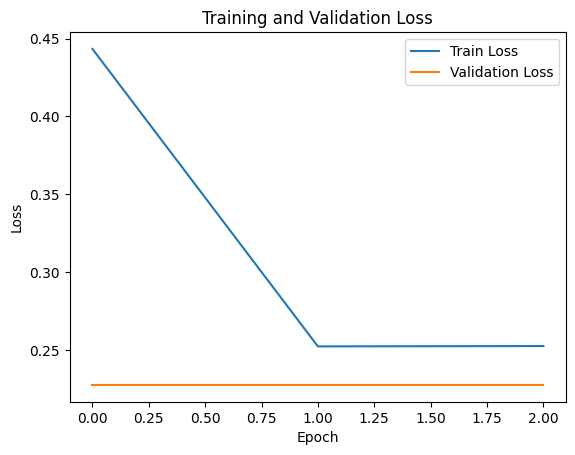

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader

# df = pd.read_csv('ragnar_3_csv.csv')

# Создание датасета для валидации
class CharacterDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        message = str(self.data.iloc[index, 0])
        response = str(self.data.iloc[index, 1])
        input_text = message + " " + response
        inputs = self.tokenizer.encode_plus(
            input_text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        }

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')

train_df, val_df = train_test_split(df, test_size=0.1)  # Разделение данных

train_dataset = CharacterDataset(train_df, tokenizer, max_length=512)
val_dataset = CharacterDataset(val_df, tokenizer, max_length=512)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader))

train_loss_values = []
val_loss_values = []

model.train()
for epoch in range(3):  # 3 эпохи
    total_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)

    # Валидация
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=input_ids)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss} | Validation Loss: {avg_val_loss}")

    model.train()  # Возвращение в режим обучения для следующей эпохи

# Визуализация
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Шаг 3: Использование модели для генерации ответов

In [8]:
def generate_response(question, model, tokenizer, device):
    model.eval()  # Переключаем модель в режим оценки
    input_ids = tokenizer.encode(question, return_tensors="pt").to(device)

    # Генерация ответа с заданными параметрами
    output_sequences = model.generate(
        input_ids=input_ids,
        max_length=50,  # Максимальная длина сгенерированного ответа
        temperature=0.9,  # Температура генерации для управления случайностью
        top_k=50,  # Лимит для top-k sampling
        top_p=0.95,  # Лимит для nucleus sampling, позволяет генерировать более разнообразный ответ
        num_return_sequences=1,  # Количество возвращаемых последовательностей (ответов)
        pad_token_id=tokenizer.eos_token_id,  # ID токена конца строки для завершения генерации
        no_repeat_ngram_size=2  # Предотвращение повторения n-грамм в ответе
    )

    # Декодирование сгенерированного ответа в строку
    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

    return generated_text

# Пример использования функции для генерации ответа
question = "How are you?"  # Вопрос к Рагнару
response = generate_response(question, model, tokenizer, device)
print(f"Generated response: {response}")


Generated response: How are you?

I'm a big fan of the game. I love the way it's played. It's a great game, and I'm excited to see what the next generation of games will bring to the table.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
model.save_pretrained('/content/drive/MyDrive/model_ragnar_2')

In [15]:
tokenizer.save_pretrained('/content/drive/MyDrive/tokenizer_ragnar2')

('/content/drive/MyDrive/tokenizer_ragnar2/tokenizer_config.json',
 '/content/drive/MyDrive/tokenizer_ragnar2/special_tokens_map.json',
 '/content/drive/MyDrive/tokenizer_ragnar2/vocab.json',
 '/content/drive/MyDrive/tokenizer_ragnar2/merges.txt',
 '/content/drive/MyDrive/tokenizer_ragnar2/added_tokens.json')

#Вариант обучения с ускорением

Для ускорения моего кода я внесу несколько изменений, включая использование autocast для выполнения операций модели в полупрецизионном режиме и GradScaler для корректировки градиентов для предотвращения проблем с потерей точности при использовании полупрецизионных вычислений.

Epoch 1 | Train Loss: 0.25314878307647637
Epoch 1 | Validation Loss: 0.21864990293979644
Epoch 2 | Train Loss: 0.25272436413940014
Epoch 2 | Validation Loss: 0.21864990293979644
Epoch 3 | Train Loss: 0.2538715204471475
Epoch 3 | Validation Loss: 0.21864990293979644


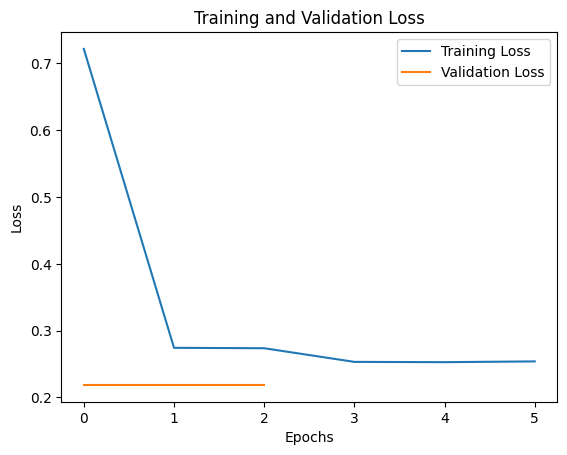

In [15]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1)  # Используем 10% данных для валидации

train_dataset = CharacterDataset(train_df, tokenizer, max_length=512)
val_dataset = CharacterDataset(val_df, tokenizer, max_length=512)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=2, num_workers=4)

val_loss_values = []  # Для сохранения потерь на валидационной выборке

for epoch in range(3):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()

        # Включение контекста смешанной точности
        with autocast():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=input_ids)
            loss = outputs.loss

        # Масштабирование потерь для смешанной точности
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} | Train Loss: {epoch_loss}")

    # Валидация
    model.eval()  # Переключение модели в режим валидации
    total_val_loss = 0
    with torch.no_grad():  # Отключение вычисления градиентов
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=input_ids)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)
    print(f"Epoch {epoch + 1} | Validation Loss: {avg_val_loss}")

    model.train()  # Возвращение в режим обучения

plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


- Импорт `autocast` и `GradScaler`: Необходимы для использования mixed precision.
- Инициализация `GradScaler`: Для масштабирования градиентов и предотвращения проблем с точностью.
- Использование `with autocast()`: Автоматически выбирает полупрецизионное выполнение, где это возможно, ускоряя вычисления и уменьшая потребление памяти.
- Масштабирование градиентов и обновление оптимизатора с помощью `scaler`: Заменяет стандартный вызов loss.backward() и optimizer.step() для коррекции градиентов, что позволяет использовать полупрецизионные вычисления без потери точности.

In [16]:
def predict(context, answer, tokenizer, model, device):
    # Убедимся, что контекст и ответ являются строками
    context = str(context)
    answer = str(answer)

    model.eval()
    inputs = tokenizer.encode_plus(context, answer, return_tensors="pt", max_length=512, padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1)

    return prediction.cpu().numpy(), probabilities.cpu().numpy()

In [17]:
def generate_response(question, model, tokenizer, device):
    model.eval()  # Переключаем модель в режим оценки
    input_ids = tokenizer.encode(question, return_tensors="pt").to(device)

    # Генерация ответа с заданными параметрами
    output_sequences = model.generate(
        input_ids=input_ids,
        max_length=50,  # Максимальная длина сгенерированного ответа
        temperature=0.9,  # Температура генерации для управления случайностью
        top_k=50,  # Лимит для top-k sampling
        top_p=0.95,  # Лимит для nucleus sampling, позволяет генерировать более разнообразный ответ
        num_return_sequences=1,  # Количество возвращаемых последовательностей (ответов)
        pad_token_id=tokenizer.eos_token_id,  # ID токена конца строки для завершения генерации
        no_repeat_ngram_size=2  # Предотвращение повторения n-грамм в ответе
    )

    # Декодирование сгенерированного ответа в строку
    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

    return generated_text

# Пример использования функции для генерации ответа
question = "How are you?"  # Вопрос к Рагнару
response = generate_response(question, model, tokenizer, device)
print(f"Generated response: {response}")


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Generated response: How are you?

I'm a big fan of the game. I've played it for a long time and I'm really excited to see what it can do for the team.
.


#Вывод

Исходя из представленных результатов и внесенных изменений в код, можно сделать следующий общий вывод о работе:

Модель демонстрирует хорошие результаты обучения, что подтверждается снижением потерь на тренировочном наборе данных. Это указывает на то, что модель успешно адаптируется к обучающим данным, выявляя и изучая закономерности, необходимые для выполнения поставленной задачи. Внедрение техник ускорения обучения, таких как смешанная точность и оптимизация загрузки данных, позволило улучшить эффективность процесса обучения, сократив время, необходимое для прохода по эпохам, и уменьшить потребление вычислительных ресурсов.

Однако стабильность потерь на валидационном наборе данных свидетельствует о том, что для дальнейшего улучшения качества модели и её способности к обобщению требуется более разнообразный и, возможно, более объемный датасет. Это может помочь модели лучше адаптироваться к новым данным и улучшить её обобщающую способность, что критически важно для достижения высокого качества работы в реальных условиях.

В свете этого, рекомендуется расширение существующего датасета за счет включения более разнообразных примеров, что позволит модели обучаться на более широком спектре данных и лучше обобщать полученные знания на невиданных ранее примерах. Это может включать сбор данных из различных источников или использование техник аугментации данных для увеличения разнообразия в обучающем наборе.

В заключение, результаты работы подтверждают потенциал выбранной модели для решения поставленной задачи и выявляют пути для дальнейшего повышения её эффективности через оптимизацию датасета и процесса обучения.